# Survival Analysis of Renal Cancer Alternative Outcomes: Tumor Recurrence

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import deva
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
renal = cptac.Ccrcc()

In [3]:
follow_up = renal.get_followup()
proteomics = renal.get_proteomics()

In [ ]:
proteomics = renal.reduce_multiindex(proteomics, levels_to_drop="Database_ID")

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will first merge the clinical and follow-up tables together for analysis. Then we will choose a few attributes to focus on, and narrow our dataframe to those attributes. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [4]:
follow_up.columns

Index(['Cohort', 'Tumor code', 'Follow-up Period', 'Lost to Follow-up?',
       'Vital Status', 'Path Diag to Last Contact(Day)', 'Cause of Death',
       'Path Diag to Death(days)', 'Adj Post-Op Radiation Therapy',
       'Adj Post-Op Pharma Therapy', 'Adj Post-Op Immuno Therapy',
       'Tumor Status', 'Success of Initial Treatment',
       'Success of Treament @ Followup', 'ECOG Score', 'Karnofsky Score',
       'Perform Status Scale: Timing', 'Other Perform Scale Timing',
       'New Tumor After Initial TRT', 'Path Diag to new Tumor days',
       'Additional Surgery ?', 'Path Diag to Surgery days     ',
       'Additional Surgery for Mets ?', 'Path Diag to Mets Surgery days',
       'Radiation for New Tumor', 'Pharmaceutical for New Tumor',
       'Immunological for New Tumor'],
      dtype='object', name='Name')

In [77]:
follow_up['New Tumor After Initial TRT'] = follow_up['New Tumor After Initial TRT'].replace('No', False)
follow_up['New Tumor After Initial TRT'] = follow_up['New Tumor After Initial TRT'].replace('Yes', True)
follow_up['New Tumor After Initial TRT'] = follow_up['New Tumor After Initial TRT'].astype(bool)

## Step 2b: Prepare data for Kaplan Meier Plotting
We will start by finding all patients that have died during the follow-up period and update the column to contain boolean values, where True denotes that the event occurred ('New Tumor Event'), and False denotes that it did not ('No New Tumor Event').  This is necessary to fit the requirements of the *lifelines* package.

In [6]:
genes = list(proteomics.columns)

In [135]:
def mergeDFs(df_genes, follow_up_df, list_genes):
    cols = ['Path Diag to Last Contact(Day)', 'Path Diag to new Tumor days']
    new_df = follow_up_df.copy()
    new_df = new_df.assign(Days_Until_Last_Contact_Or_New_Tumor_Event=new_df[cols].sum(1)).drop(cols, 1)
# 'Success of Initial Treatment', 'Success of Treament @ Followup', 'Tumor Status', 
    cols_of_interest = ['New Tumor After Initial TRT', 
                        'Days_Until_Last_Contact_Or_New_Tumor_Event']
    test_df = pd.merge(new_df[cols_of_interest], 
                       df_genes[list_genes], 
                       left_on=new_df[cols_of_interest].index, 
                       right_on=df_genes[list_genes].index)
    test_df.index = test_df['key_0']
    test_df = test_df.drop("key_0", axis=1)
    return test_df
    #df_clean = test_df.dropna(axis=0, how='any')
    #return df_clean

In [67]:
def rapidTTest(df_genes, follow_up_df, list_genes, results_dict):
    clinical_attribute = 'New Tumor After Initial TRT'
    df_clean = mergeDFs(df_genes, follow_up_df, list_genes)
    no_tumor = df_clean[df_clean[clinical_attribute] == 'No']
    tumor = df_clean[df_clean[clinical_attribute] == 'Yes']
    for data_col in list_genes:
        stat, p_val = scipy.stats.ttest_ind(tumor[data_col], no_tumor[data_col])
        if (isinstance(p_val, float)):
            if p_val < 0.05:
                results_dict[data_col] = p_val
        else:
            to_add = set()
            for val in p_val:
                if (isinstance(val, float)):
                    if val < 0.05:
                        to_add.add(val)
            if len(to_add) > 0:
                results_dict[data_col] = min(to_add)

In [68]:
results_dict = {}
for i in range(0, len(genes), 5):
    rapidTTest(proteomics, follow_up, genes[i:i+5], results_dict)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\Daniel\App

In [71]:
test_df = pd.DataFrame(results_dict, index = range(0,1))

In [72]:
test_df = test_df.T

In [73]:
test_no_zeros = test_df[test_df[0] != 0.0]
test_only_zeros = test_df[test_df[0] == 0.0]

In [181]:
very_sig_no_zeros = test_no_zeros[test_no_zeros[0] < 0.02]
all_sigs = test_df[test_df[0] < 0.05]

In [213]:
list(very_sig_no_zeros.columns)

[0]

In [185]:
sig_genes = list(very_sig_no_zeros.index)

In [267]:
def splitGenesByExpression(genes_list, df):
    df_genes = df.copy()
    col_set = set(df_genes.columns)
    if (len(col_set) != len(df_genes.columns)):
        duplicate_dict = {}
        new_cols = []
        for col in df_genes.columns:
            if col not in duplicate_dict.keys():
                duplicate_dict[col] = 0
                new_cols.append(col)
            else:
                duplicate_dict[col] += 1
                new_name = col + "(" + str(duplicate_dict[col]) + ")"
                new_cols.append(new_name)
        df_genes.columns = new_cols
    for col in genes_list:
        lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)
        upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)

        df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])
        df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])
        df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])


    proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
    for gene in genes_list:
        df_genes[gene] = df_genes[gene].map(proteomics_map)
    df_genes = df_genes.dropna(axis=0, how='any')
    return df_genes.copy()

# Step 3: Kaplan-Meier Plots
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts.

Here, we show a general Kaplan Meier Plot of survival overall for our cohort, using the KaplanMeierFitter() from the lifelines package.

In [268]:
def plotBasicKaplanMeier(time_col, status_col, df):
    time = df[time_col]
    status = df[status_col]

    kmf = KaplanMeierFitter()
    kmf.fit(time, event_observed = status)
    kmf.plot()

In [269]:
def plotMultivariateKaplanMeier(list_genes, df, time_col, status_col, print_summary):
    cph = CoxPHFitter()
    cph.fit(df, duration_col = "Days_Until_Last_Contact_Or_New_Tumor_Event", 
            event_col = "New Tumor After Initial TRT")
    results = proportional_hazard_test(cph, df, time_transform='rank')
    if print_summary:
        results.print_summary(decimals=3, model="untransformed variables")
    results_df = results.summary
    risk_genes = list(results_df[results_df['p'] < .05].index)
    print("\nOut of genes:", list_genes, ", there are ", len(risk_genes), "significant genes:\n")
    if len(risk_genes) > 0:
        print(risk_genes, '\n')
        for attribute in risk_genes:
            cph.plot_covariate_groups(attribute, [0,1, 2], cmap='coolwarm', 
                                      title= "Renal Cancer Tumor Recurrance Risk: " + attribute)
#     cph.print_summary(model="untransformed variables", decimals=3)

# Step 4: Format data for Cox's Proportional Hazard test

With the CoxPHFitter from the lifelines package we can see covariate survival plots, as shown below.  The variables we are interested in exploring are Tumor Stage, RAC2, and PODXL protein abundance.

First we will fit our model to the data we have prepared using the CoxPHFitter() class from the lifelines module.

In [270]:
sig_genes[-4:-1:1]

['ZFAND5', 'ZFC3H1', 'ZNF446']


Out of genes: ['AAMP', 'ABCF1', 'ABHD14B'] , there are  0 significant genes:


Out of genes: ['ABLIM1', 'ACOT13', 'ADSS'] , there are  0 significant genes:


Out of genes: ['AGPAT2', 'AHCYL1', 'AHCYL2'] , there are  0 significant genes:


Out of genes: ['AHSG', 'AHSP', 'AKAP7'] , there are  0 significant genes:


Out of genes: ['AKAP8', 'ALDH3B1', 'ALDH8A1'] , there are  0 significant genes:


Out of genes: ['ALG2', 'ALKBH2', 'APOC4'] , there are  0 significant genes:


Out of genes: ['APOL6', 'ASL', 'ASNS'] , there are  0 significant genes:


Out of genes: ['ATG3', 'ATL2', 'ATP5MF'] , there are  0 significant genes:


Out of genes: ['ATP6AP2', 'AZI2', 'BCKDK'] , there are  0 significant genes:


Out of genes: ['BIRC6', 'BNIP3L', 'C19orf12'] , there are  0 significant genes:


Out of genes: ['C19orf25', 'C1orf109', 'C1orf116'] , there are  0 significant genes:


Out of genes: ['CADPS2', 'CALU', 'CASP10'] , there are  0 significant genes:


Out of genes: ['CAST', 'CCDC88A', 'CCL5'] , t


['RPL37'] 


Out of genes: ['RPS20', 'RPS23', 'RPS6KB2'] , there are  0 significant genes:


Out of genes: ['RRAS', 'RUNX3', 'SCARB1'] , there are  0 significant genes:


Out of genes: ['SCARB2', 'SCCPDH', 'SDHAF3'] , there are  0 significant genes:


Out of genes: ['SEC23IP', 'SEC24B', 'SELENOO'] , there are  0 significant genes:


Out of genes: ['SENP6', 'SERF1B', 'SERPINB1'] , there are  0 significant genes:


Out of genes: ['SERPINB6', 'SERPINB9', 'SERPINC1'] , there are  0 significant genes:


Out of genes: ['SERPINE1', 'SF1', 'SFT2D3'] , there are  0 significant genes:


Out of genes: ['SH2D2A', 'SH3BGRL', 'SHMT2'] , there are  0 significant genes:


Out of genes: ['SIDT2', 'SIKE1', 'SIRT4'] , there are  0 significant genes:


Out of genes: ['SLC25A21', 'SLC25A24', 'SLC35A2'] , there are  0 significant genes:


Out of genes: ['SMC6', 'SMPDL3A', 'SMTN'] , there are  0 significant genes:


Out of genes: ['SNX24', 'SPC25', 'SPON1'] , there are  0 significant genes:


Out of genes: 

C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)



Out of genes: ['UPF3A', 'URI1', 'URM1'] , there are  0 significant genes:


Out of genes: ['USP14', 'USP30', 'USP8'] , there are  1 significant genes:

['USP30'] 



C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)



Out of genes: ['UTP3', 'VAMP3', 'VAMP8'] , there are  1 significant genes:

['VAMP3'] 



C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)



Out of genes: ['VIPR1', 'VPS13B', 'VPS33B'] , there are  1 significant genes:

['VPS13B'] 



C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)



Out of genes: ['VTA1', 'WASF1', 'WASHC2C'] , there are  0 significant genes:


Out of genes: ['WDFY1', 'WDR37', 'YARS'] , there are  0 significant genes:


Out of genes: ['YWHAG', 'ZC3H12A', 'ZFAND5'] , there are  1 significant genes:

['ZC3H12A'] 



C:\Users\Daniel\AppData\Roaming\Python\Python36\site-packages\lifelines\fitters\coxph_fitter.py:1832: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)



Out of genes: ['ZFC3H1', 'ZNF446', 'ZYX'] , there are  0 significant genes:



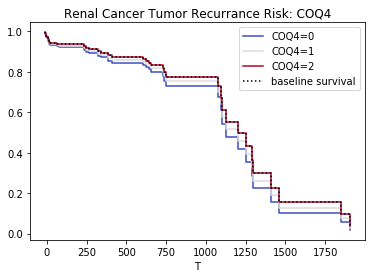

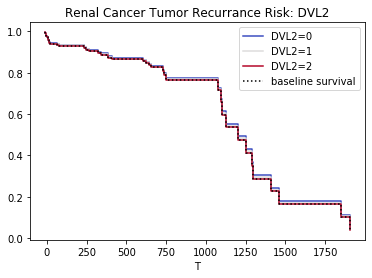

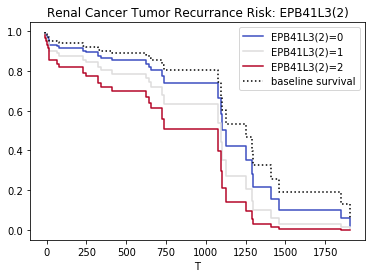

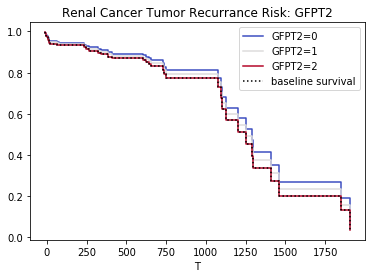

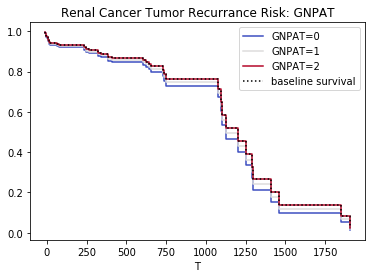

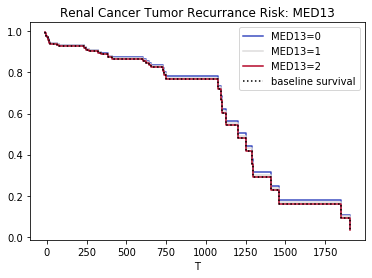

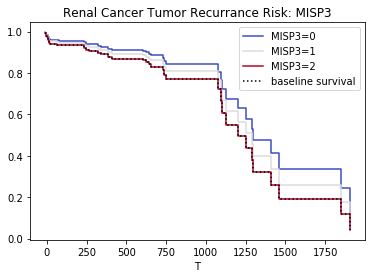

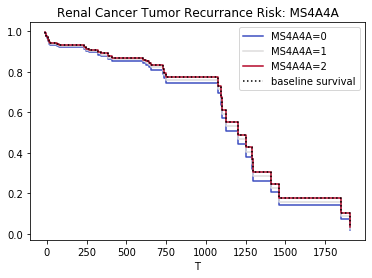

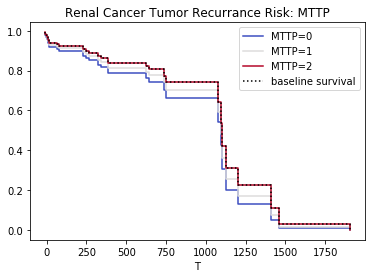

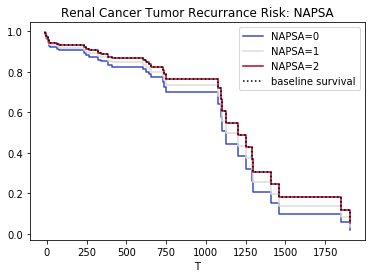

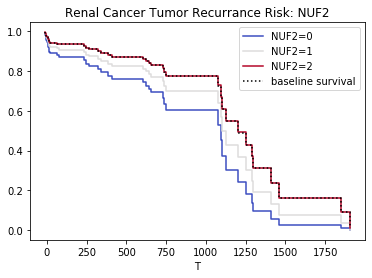

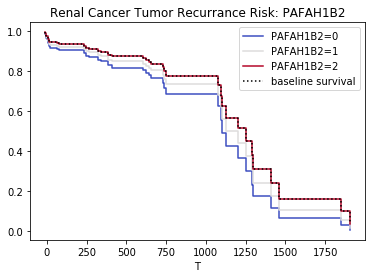

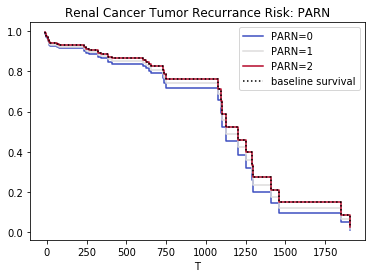

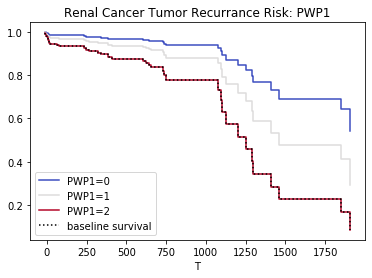

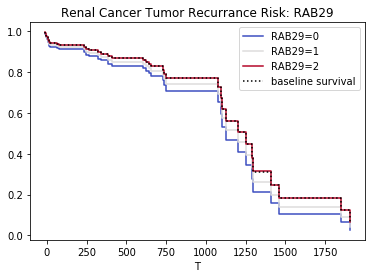

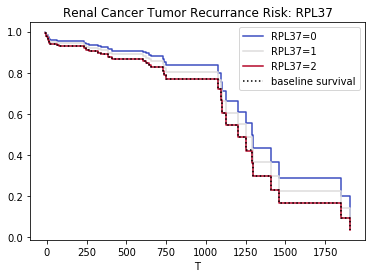

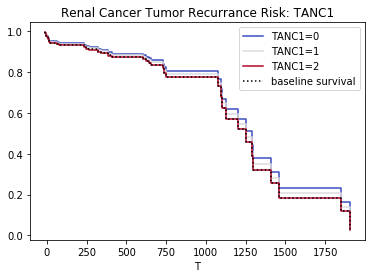

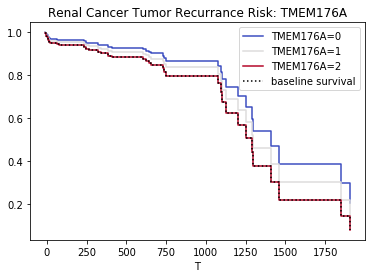

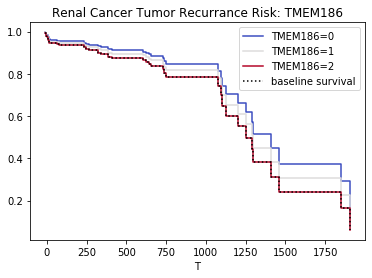

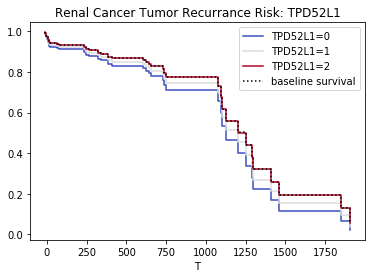

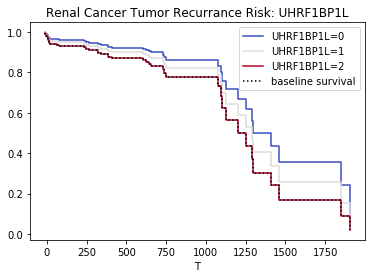

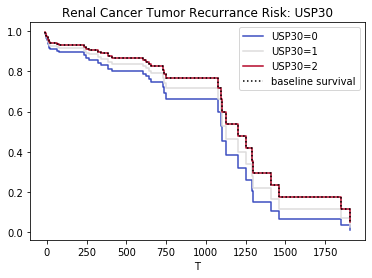

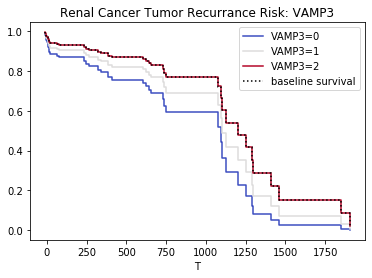

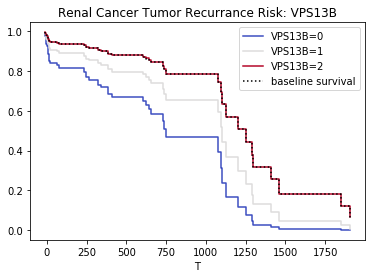

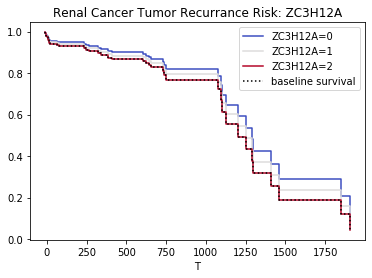

In [271]:
time_col = 'Days_Until_Last_Contact_Or_New_Tumor_Event'
status_col = 'New Tumor After Initial TRT'

for i in range(0, len(sig_genes), 3):
    genes_list = sig_genes[i:i+3]
    merged_df = mergeDFs(proteomics, follow_up, genes_list)
    merged_df_clean = splitGenesByExpression(genes_list, merged_df)
    plotMultivariateKaplanMeier(genes_list, merged_df_clean, time_col, status_col, print_summary=False)

Then we will plot each of the attributes to see how different levels of protein or different tumor stages affect survival outcomes in Ovarian Cancer patients.

# Results
These different analyses tend to follow the baseline survival function, however, there are some differences in varying levels of each attribute. For example, FIGO Stage I tumors tend to have a higher survival rate over time comparatively to Stage III tumors.  We can explore these differences with the CoxPHFitter object's *print_summary* function (which prints out results for multivariate linear regression) and with the *proportional_hazard_test* (which performs Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival).